 # Primeiro Questionamento

## Quais os sintomas mais relacionados a óbitos por COVID-19?

Sabemos que os principais sintomas por covid são febre, tosse e falta de ar. Porém, não sabemos quais, a priori, são os mais responsáveis pelos óbitos. Com isso, queremos analisar qual sintoma mais frequente em óbitos de pessoas com teste positivo para covid-19, ao mesmo tempo em que não é tão frequente em pessoas que se recuperaram.



## Inicialização

In [3]:
from scipy.stats import chi2_contingency, norm
from math import sqrt
import pandas
import matplotlib.pyplot as plt
import numpy as np

In [4]:
df = pandas.read_csv('dados-es.csv', delimiter=';', encoding='latin1')

In [5]:
# Limpando os dados, tirando dados nulos e coletando apenas os testes positivos de covid-19
# e com evolução do caso sendo Óbito ou Cura

df = df[df['evolucaoCaso'].isnull()==False]
df = df[df['sintomas'].isnull()==False]
df = df[df['resultadoTeste']=='Positivo']
df = df[df['evolucaoCaso'].isin(['Óbito', 'Cura'])]

In [6]:
# Dados dos Óbitos
df_obitos = df[df['evolucaoCaso']=='Óbito']

# Dados dos Recuperados
df_rec = df[df['evolucaoCaso']=='Cura']

In [7]:
# Computa frequencia dos sintomas de obitos

def compute_freq(d, l=True):
    f = {}
    for sintomas in d['sintomas']:
        sintomas = sintomas.strip()
        if l:
            sintomas = sintomas.lower()
            sintomas = sintomas.replace(' ', '')
        for sintoma in sintomas.split(','):
            if len(sintoma) == 0:
                continue
            if sintoma.strip() not in f:
                f[sintoma.strip()] = 0
            f[sintoma.strip()] += 1
    return f



---
## Erro no Intervalo de Confiança de 95%

Inicialmente vamos conferir se os dados são confiáveis. Para isso, calcularemos o intervalo de confiança para proporção com relação a cada sintoma, pois, dessa forma, conseguiremos analisar se a quantidade de dados é suficiente para realizar inferências.

In [8]:
#sintomas de quem teve óbito e foi curado
sintomas_all = compute_freq(df, l=False)

for sintoma in sintomas_all:
    n = sintomas_all[sintoma]
    print(sintoma)
    print(norm.ppf(0.025)/sqrt(4*n), end='\n\n')

Tosse
-0.002942915405086112

Febre
-0.0032639783831580984

Outros
-0.05486845783435862

Dispneia
-0.004763146739263596

Dor De Garganta
-0.21384960282242996

Dor de Garganta
-0.004170702590805473

Distúrbios Olfativos
-0.005985299512111663

Distúrbios Gustativos
-0.006127041868617299

Assintomático
-0.007604303243317258

Coriza
-0.004374701645942631

Dor de Cabeça
-0.09849189605044383

Distúrbios olfativos
-0.5657928670380861

Distúrbios gustativos
-0.4899909961350136



Como podemos ver, usando um intervalo com 95% de confiança, os erros da maior parte das estatísticas a serem analisadas são bastante pequenos. No entanto, o erro do sintoma "Dor de Cabeça" acaba sendo inadequado para ser analisado. Além disso, foram desconsiderados para análise os valores que estão repetidos
e com um erro elevado.

## Análise da Proporção de Óbito em Pacientes com Determinado Sintoma


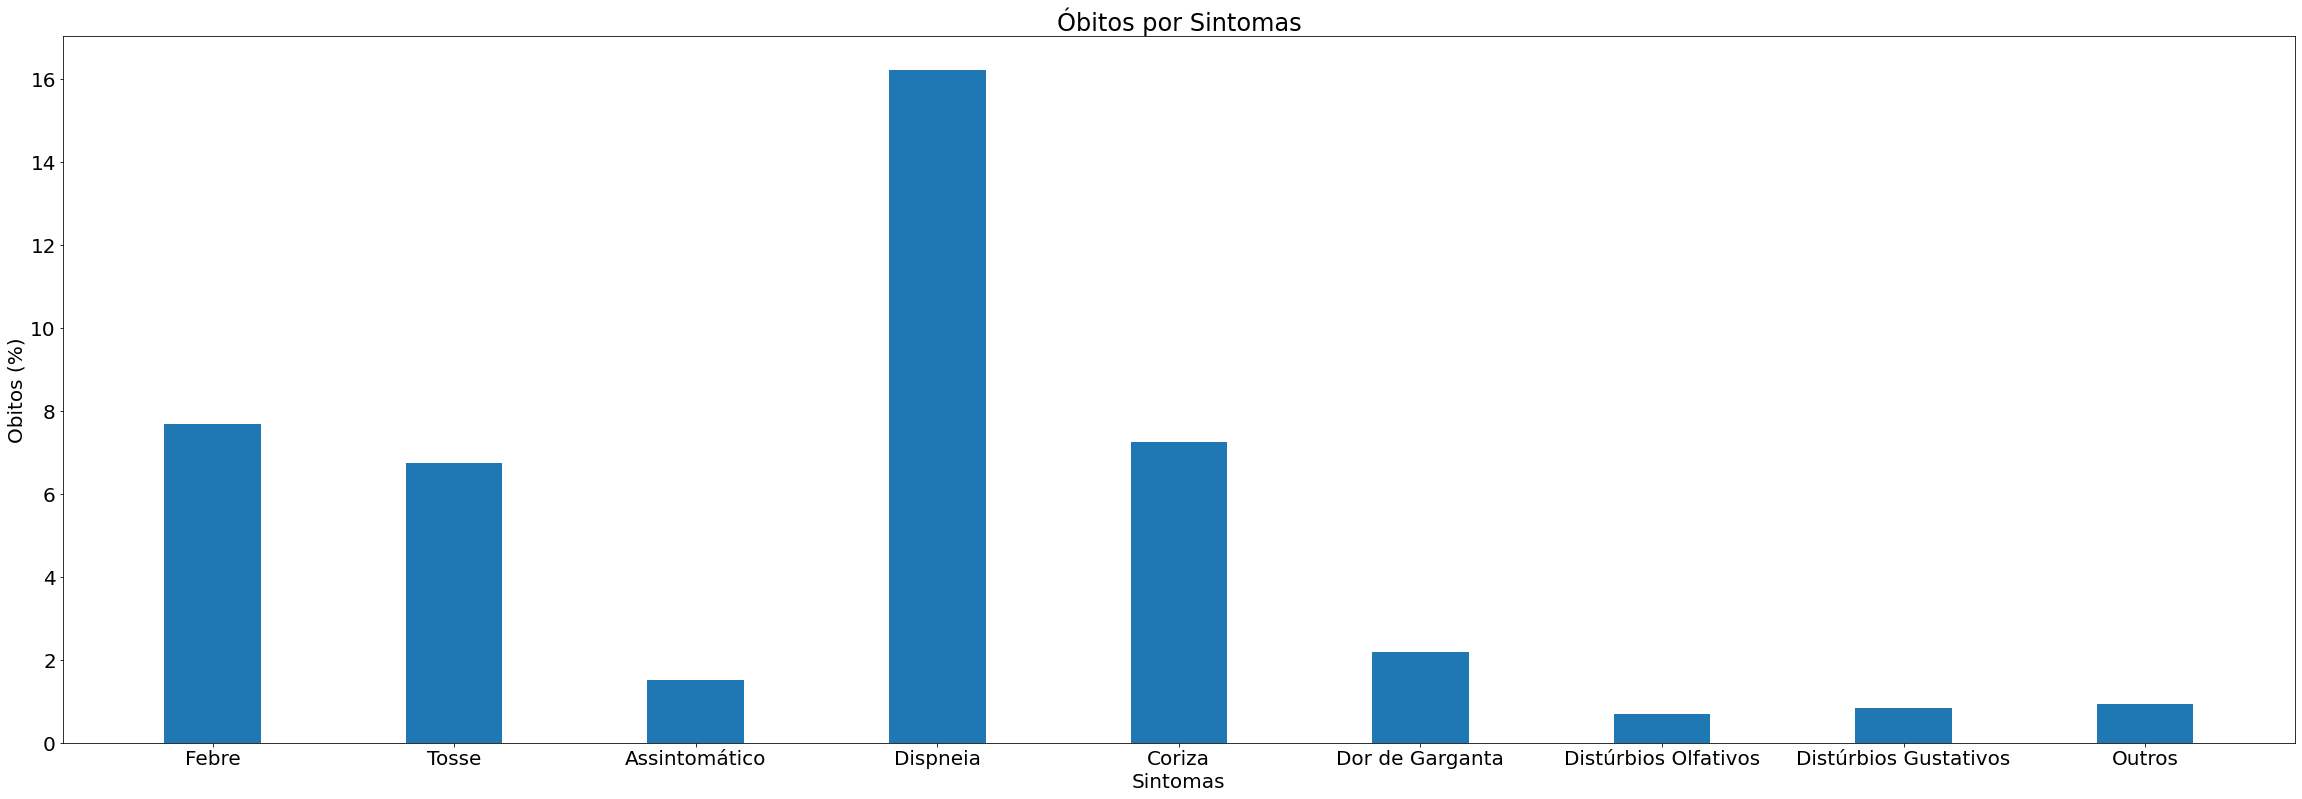

In [11]:
# Realiza o plot do gráfico

sintomas_obito = compute_freq(df_obitos, l=False)

#junta os dois "dor de garganta"
sintomas_obito['Dor de Garganta'] += sintomas_obito['Dor De Garganta']
del sintomas_obito['Dor De Garganta']

sintomas_obito_nomes = [s for s in sintomas_obito]

taxa_obitos = [100*sintomas_obito[s]/(sintomas_all[s]) for s in sintomas_obito]



f = plt.figure()
f.set_figwidth(40)
f.set_figheight(13)

plt.title('Óbitos por Sintomas')

plt.ylabel("Obitos (%)")
plt.xlabel("Sintomas")

plt.rc('font', size=10) 
plt.bar(sintomas_obito_nomes, taxa_obitos, width=0.4)
plt.show()

Como mostrado no gráfico, a dispineia é o sintoma que está mais relacionado a óbitos, com cerca de 16% dos casos com este sintoma tendo culminado em morte.

## Análise Inferencial

Os sintomas devem com certeza estar relacionados ao óbito. Mas podemos afirmar que existe dependência entre as variáveis óbito e sintoma? Para responder essa questão, usaremos teste qui-quadrado para verificar a interdependência dos dados.

Então, para cada um dos sintomas, faremos uma tabela (A, B, C, D) contendo o número de mortes pelo sintoma analisado.

In [10]:
chi_sintomas = []

sintomas_rec = compute_freq(df_rec, l=False)

for s in sintomas_obito:
    A = sintomas_obito[s]
    B = len(df_obitos) - A
    C = sintomas_rec[s]
    D = len(df_rec) - C
    
    chi_sintomas.append((s, chi2_contingency( np.array ([[A,B],[C,D]]) )))

chi_sintomas.sort(key = lambda k1: k1[1][0], reverse=True)  

for sintoma, chi in chi_sintomas[:-1]:
    print(f'{sintoma}:\nz = {chi[0]}\np-value = {chi[1]}')
    print()
    

Dispneia:
z = 14470.149009258112
p-value = 0.0

Febre:
z = 2686.572691329994
p-value = 0.0

Tosse:
z = 1787.2388988181701
p-value = 0.0

Dor de Garganta:
z = 1402.9095442043326
p-value = 4.899811590021444e-307

Distúrbios Olfativos:
z = 1260.9952740099732
p-value = 3.3852831671172155e-276

Distúrbios Gustativos:
z = 1116.2662654874546
p-value = 9.627826402497673e-245

Coriza:
z = 694.734998325629
p-value = 4.1746445643378e-153

Assintomático:
z = 485.09339187403725
p-value = 1.6651180187486216e-107



Feito isso, percebemos que, na verdade, há dependência com relação em todos os sintomas, visto que o p-value de todos eles foi zero (ou aproximadamente).

## Conclusão

Podemos concluir, feito a análise inferencial, que a dispineia é o sintoma que possui maior relação com casos de óbitos de pessoas que tiveram covid-19, tendo em vista que ela teve o maior valor significativo no teste Qui-Quadrado, isto é, é o sintoma que possui maior probabilidade de ter dependência com os óbitos.